In [1]:
%load_ext autoreload
%autoreload 2

## 🧠 Segmentation Inference with Octopi 🐙: Predicting Macromolecules in Cryo-ET Tomograms

This tutorial walks you through applying a trained Octopi model to perform segmentation inference on experimental cryo-electron tomography (Cryo-ET) datasets.

You will learn how to:

	•	Load trained models
	•	Run inference to generate 3D segmentation masks
	•	Convert those masks into coordinate predictions
	•	Evaluate prediction quality by comparing to ground truth coordinates

The pipeline supports flexible input sources via the CoPick configuration system, which enables seamless switching between local data and datasets hosted on a data portal.

### 🔍 Step 3: Perform Segmentation Inference on Test Dataset

With a trained model in hand, it's time to move forward with making predictions. In this step, you will execute model inference using a checkpoint from a saved epoch, allowing you to evaluate the model's performance on your test dataset.

In [3]:
from octopus.pytorch import segmentation

########### Input Parameters ###########

# Copick Query for Tomograms to Run Inference On
config = "../config.json"
tomo_algorithm = 'wbp-denoised-denoiset-ctfdeconv'
voxel_size = 10.012

# Path to Trained Model
model_weights = 'results/best_model.pth'
model_config = 'results/training_parameters.yaml'

# Adjust this parameter based on available GPU and RAM space
tomo_batch_size = 15

# RunIDs to Run Inference On
run_ids = None

# Output Save Information (Segmentation Name, UserID, SessionID)
seg_info = ['predict', 'DeepFindET', '1']

#### ⚙️ Create the Dataloader and Run Inference with the Model

We’ll now create the data pipeline to feed tomographic data into the model and execute inference. This notebook uses a convenient Python interface for inference, but if you’re working outside the notebook or at scale, you can run the equivalent command-line tool:

```
octopus inference 
```

Instead of applying the model across an entire CoPick project, we’ll focus on a curated test set. These are specific experimental RunIDs that were withheld from training, allowing for an unbiased evaluation of the model’s generalization. To see which runs were withheld for either a valdiation or test datset, look at the saved `*.yaml` file stored in the results directory under the dataloader section.  

One advantage of the CoPick configuration system is that it abstracts away data locations. Whether your tomograms live locally or are accessible via a remote data portal, inference runs the same — letting you work seamlessly across data sources.

In [4]:
print("Using Single-GPU Predictor.")
predict = segmentation.Predictor(
    config,
    model_config,
    model_weights,
)

# Run batch prediction
predict.batch_predict(
    runIDs=run_ids,
    num_tomos_per_batch=tomo_batch_size,
    tomo_algorithm=tomo_algorithm,
    voxel_spacing=voxel_size,
    segmentation_name=seg_info[0],
    segmentation_user_id=seg_info[1],
    segmentation_session_id=seg_info[2]
)

Using Single-GPU Predictor.
Running Inference On:  cuda


/mnt/jonathan/envs/pyUNET/lib/python3.10/site-packages/monai/networks/nets/unet.py:130: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


Running Inference on the Follow RunIDs:  ['16463', '16464', '16465', '16466', '16467', '16468', '16469']


100%|██████████| 2/2 [00:33<00:00, 16.68s/it]


Predictions Complete!


#### (Optional) Visualize the Segmentation

This is an extension of the tutorial from the `inspect_segmentation_targets.ipynb` notebook. Refer to that tutorial to a written description of this code

In [2]:
from ipywidgets import interact, IntSlider, fixed
from octopus import io, visualization_tools

# Specify the Query for Obtaining the Target Segmentation and Corresponding Tomogram
voxel_size = 10.012
seg_name = 'targets'
algorithm = 'wbp-denoised-denoiset-ctfdeconv'

# Experimental RunIDs
config = "../config.json"
run_ids = ['16463']

# Load the Following tomograms
root = io.load_copick_config(config)
files = io.load_training_data(root, run_ids, voxel_size, algorithm, seg_name)

Loading Training Data: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


Launch the interactive widget

In [3]:
# Determine which Tomgoram and Corresponding Segmentation to visualize
tomo_index = 0
tomo = files[tomo_index]['image']
seg = files[tomo_index]['label']

# Get the number of slices for the slider range
max_slices = tomo.shape[0] - 1
middle_slice = int(max_slices // 2)

# Launch the Interactive Widget
interact(
    visualization_tools.show_tomo_segmentation, 
    tomo=fixed(tomo), seg=fixed(seg), 
    vol_slice=IntSlider(min=0, max=max_slices, step=1, value=middle_slice)
)

interactive(children=(IntSlider(value=91, description='vol_slice', max=183), Output()), _dom_classes=('widget-…

<function octopus.visualization_tools.show_tomo_segmentation(tomo, seg, vol_slice)>

Lets show a static image for reference

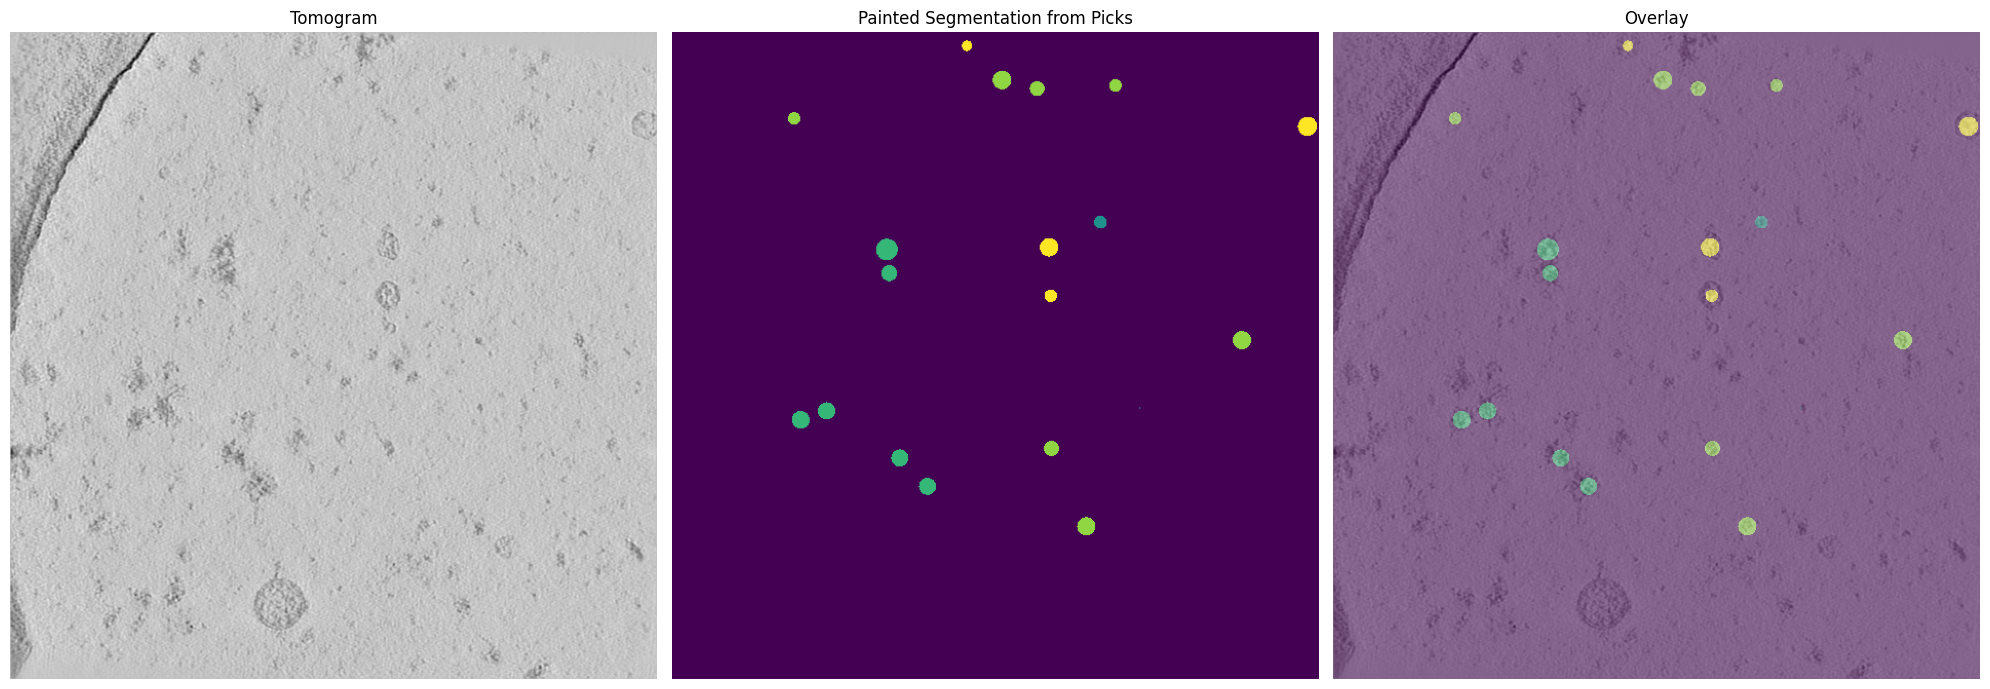

In [4]:
visualization_tools.show_tomo_segmentation(
    tomo, seg, vol_slice=middle_slice
)

### 📍 Step 4: Converting Segmentation Masks to 3D Coordinates

In this step, we convert the segmentation masks predicted by the model into discrete 3D coordinate locations representing the centers of macromolecules. You can run the equivalent CLI tool:
```
octopus localize --help
```

Each segmentation mask highlights regions in the tomogram where the model believes a specific macromolecule is present. To transform these continuous volumetric predictions into biologically meaningful particle coordinates, we apply a post-processing pipeline that includes:

	•	Thresholding the segmentation mask to isolate high-confidence regions
	•	Size filtering based on expected macromolecule volume (e.g., diameter or voxel count)
	•	Centroid extraction from connected components that match the size profile

This process enables us to generate a precise list of coordinates that can be directly compared to ground truth annotations or used as input for downstream structural analysis.

By tuning the filtering parameters (e.g., minimum/maximum particle size), the pipeline can be adapted to different targets such as ribosomes, proteasomes, or other cellular components.

In [6]:
from octopus.extract import localize
from tqdm import tqdm
import copick

########### Input Parameters ###########

# Copick Query for Tomograms to Run Inference On
config = "../config.json"

# Voxel Size of Segmentation Maps
voxel_size = 10.012

# Information for the Referenced Segmentation Map 
seg_info = ['predict', 'DeepFindET', '1']

# Information for the Saved Pick Session
pick_user_id = 'octopus'; pick_session_id = '1'

# Information for the Localization Method
method = 'watershed'; filter_size = 10

# Save of Segmentation Spheres that are Valid for Coordinates
radius_min_scale = 0.5; radius_max_scale = 1.5

# RunIDs to Run Localization On
runIDs = None

# List of Objects to Localize 
# (We can Either Specify Specific Objects to Localize or None to Find All Objects)
pick_objects = None

Now lets start a little pre-processing. 

In [3]:
# Load the Copick Config
root = copick.from_file(config) 

# Get objects that can be Picked
objects = [(obj.name, obj.label, obj.radius) for obj in root.pickable_objects if obj.is_particle]

# Verify each object has the required attributes
for obj in objects:
    if len(obj) < 3 or not isinstance(obj[2], (float, int)):
        raise ValueError(f"Invalid object format: {obj}. Expected a tuple with (name, label, radius).")

# Filter elements
if pick_objects is not None:
    objects = [obj for obj in objects if obj[0] in pick_objects]

print(f'Running Localization on the Following Objects: ')
print(', '.join([f'{obj[0]} (Label: {obj[1]})' for obj in objects]) + '\n')

# Either Specify Input RunIDs or Run on All RunIDs
if runIDs:  print('Running Localization on the Following RunIDs: ' + ', '.join(runIDs) + '\n')
run_ids = runIDs if runIDs else [run.name for run in root.runs]
n_run_ids = len(run_ids)

Running Localization on the Following Objects: 
apoferritin (Label: 1), beta-amylase (Label: 2), beta-galactosidase (Label: 3), ribosome (Label: 4), thyroglobulin (Label: 5), virus-like-particle (Label: 6)



In [7]:
# Main Loop
for run_id in tqdm(run_ids):

    # Run Localization on Given RunID
    run = root.get_run(run_id)
    localize.processs_localization(
        run,
        objects,
        seg_info,
        method,
        voxel_size,
        filter_size,
        radius_min_scale, radius_max_scale,
        pick_session_id, pick_user_id,
    )

100%|██████████| 7/7 [07:55<00:00, 68.00s/it]


#### (Optional): Visualize the Coordinates

Octopus contains two functions that allows users to assess the localized coordiantes. First is `show_tomo_points` that overlays the coordinates over the tomogram. The second function `compare_tomo_points` compares coordinates stemming from two sources. This is particularly useful when comparing two picking algorithms, or the a model against the ground truth. 

In [4]:
from ipywidgets import interact, IntSlider, fixed
from octopus import visualization_tools, io
import copick

# Copick Query for Tomograms to Run Inference On
config = "../config.json"
tomo_algorithm = 'wbp-denoised-denoiset-ctfdeconv'
voxel_size = 10.012

# Read the Copick Project
root = copick.from_file(config)

# Get objects that can be Picked
objects = [(obj.name, obj.label, obj.radius) for obj in root.pickable_objects if obj.is_particle]

Launch the interactive widget

In [ ]:
# Specify the RunID from Validation Set
runID = '16463'

# Get the run and associated tomogram
run = root.get_run(runID)
vol = io.get_tomogram_array(run, voxel_size, tomo_algorithm)

# Get the number of slices for the slider range
max_slices = vol.shape[0] - 1
middle_slice = int(max_slices // 2)

interact(
    visualization_tools.show_tomo_points, 
    tomo=fixed(vol), run=fixed(run), objects=fixed(objects), 
    user_id=fixed('octopus'),
    vol_slice=IntSlider(min=0, max=max_slices, step=1, value=middle_slice), 
    session_id = fixed(None),
    slice_proximity_threshold = fixed(5)
)

interactive(children=(IntSlider(value=91, description='vol_slice', max=183), Output()), _dom_classes=('widget-…

<function octopus.visualization_tools.show_tomo_points(tomo, run, objects, user_id, vol_slice, session_id=None, slice_proximity_threshold=3)>

Lets show a static image for reference

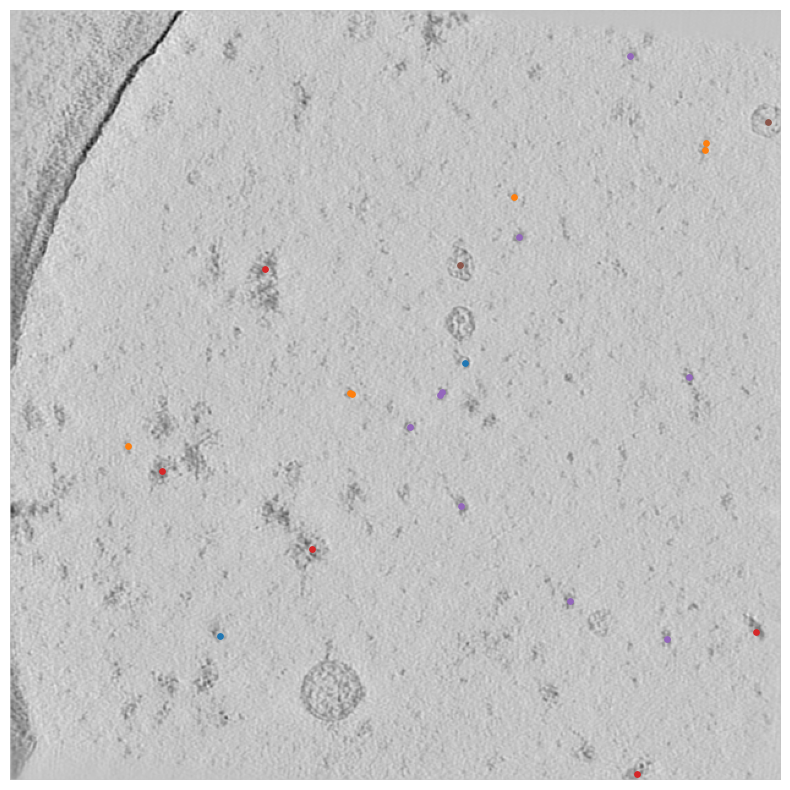

In [8]:
visualization_tools.show_tomo_points(
    vol, run, objects,
    user_id='octopus',
    vol_slice=middle_slice,
    session_id=None,
    slice_proximity_threshold=5
)

### 📊 Step 5: Evaluating the Predicted Coordinates 

In this step, we evaluate the accuracy of the 3D protein coordinates predicted by the trained model. These coordinates, derived from segmentation masks, are compared against manually annotated ground truth positions to assess the model’s performance in detecting macromolecules within Cryo-ET tomograms.
```
octopus evaluate --help
```
Using the evaluator class from octopus.processing.evaluate, we compute a comprehensive set of object-level metrics for each tomogram and macromolecular species, including:
1. Precision, 2. Recall, 3. F1 Score, $F_{\beta}$ Score 4. Type I & II Error (True/False Positives / Negatives)

The evaluation is performed per particle type (e.g., ribosome, apoferritin) and per tomogram, then aggregated across all run IDs.

#### ⚙️ Evaluation Details

For the Machine Learning Challenge, the designated evaluation metric was the Fβ score with β = 4 and a distance threshold scale of 0.5. This configuration accounts for potential incompleteness in ground truth annotations while emphasizing recall — ensuring that predicted coordinates are not just present, but accurately centered on the macromolecule.

This evaluation framework provides a robust and standardized approach to benchmark instance segmentation models for Cryo-ET. It is essential for:

	•	Measuring predictive performance across particle types
	•	Comparing model variants and optimization strategies
	•	Participating in formal benchmarking tasks like the CZ Imaging Institute ML Challenge

In [2]:
import octopus.processing.evaluate as evaluate

########### Input Parameters ###########

config = '../config.json'

# Information for the Ground Truth Segmentation Map 
ground_truth_user_id = 'data-portal'
ground_truth_session_id = None

# Information for the Predicted Segmentation Map 
predict_user_id = 'octopus'
predict_session_id = '1'

# Information for the Objects to Evaluate 
object_names = None

# Distance Threshold Scale
distance_threshold_scale = 0.5

# RunIDs to Run Evaluation On
runIDs = ['16463']

In [14]:
eval = evaluate.evaluator(
        config,
        ground_truth_user_id,
        ground_truth_session_id,
        predict_user_id,
        predict_session_id, 
        object_names=object_names
    )

eval.run(distance_threshold_scale=distance_threshold_scale, runIDs=runIDs)

Running Evaluation on the Following Copick Project:  ../config.json

Ground Truth Query: 
UserID: data-portal, SessionID: None

Submitted Picks: 
UserID: octopus, SessionID: 1

No object names provided, using all pickable objects
Using the following valid objects: ['apoferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

Running Metrics Evaluation on the Following RunIDs:  ['16463']



Average Metrics Summary:
apoferritin: [Recall: 0.891 ± 0.000, Precision: 0.695 ± 0.000, F1 Score: 0.781 ± 0.000, F_beta Score: 0.877 ± 0.000, False_Positives: 18.0 ± 0.0, False_Negatives: 5.0 ± 0.0]
beta-amylase: [Recall: 0.625 ± 0.000, Precision: 0.125 ± 0.000, F1 Score: 0.208 ± 0.000, F_beta Score: 0.506 ± 0.000, False_Positives: 35.0 ± 0.0, False_Negatives: 3.0 ± 0.0]
beta-galactosidase: [Recall: 0.700 ± 0.000, Precision: 0.292 ± 0.000, F1 Score: 0.412 ± 0.000, F_beta Score: 0.647 ± 0.000, False_Positives: 17.0 ± 0.0, False_Negatives: 3.0 ± 0.0]
ribosome: [Recall: 0.848 ± 0.000, Precision: 0.651 ± 0.000, F1 Score: 0.737 ± 0.000, F_beta Score: 0.834 ± 0.000, False_Positives: 15.0 ± 0.0, False_Negatives: 5.0 ± 0.0]
thyroglobulin: [Recall: 0.767 ± 0.000, Precision: 0.359 ± 0.000, F1 Score: 0.489 ± 0.000, F_beta Score: 0.719 ± 0.000, False_Positives: 41.0 ± 0.0, False_Negatives: 7.0 ± 0.0]
virus-like-particle: [Recall: 1.000 ± 0.000, Precision: 1.000 ± 0.000, F1 Score: 1.000 ± 0.000, F